<a href="https://colab.research.google.com/github/shadab4150/X_Ray_Covid_19_pnemonia_detection/blob/master/chest_xray_segmentation_lungs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as immg
import gc
import numpy as np
from scipy import signal
from scipy import misc
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!unzip '/content/drive/My Drive/Dataset/chest_mask.zip' -d '/content/chest/'

In [0]:
path = Path('/content/chest')

In [7]:
path.ls()

[PosixPath('/content/chest/masks'),
 PosixPath('/content/chest/train'),
 PosixPath('/content/chest/.ipynb_checkpoints')]

# Data

In [0]:
fnames = get_image_files(path/'train')
fnamesMask = get_image_files(path/'masks')

In [0]:
path_lbl = path/'masks'
path_img = path/'train'
get_y_fn = lambda x: path_lbl/f'{x.stem}_mask{x.suffix}'
codes = np.array([0,1])

In [0]:
sns.set_style('darkgrid')

## Function to show chest X_ray with Mask

In [0]:
def show_chest(f):  # f = file_name
  img_a = immg.imread(f)
  img_a_mask = immg.imread(get_y_fn(f))
  plt.figure(1,figsize=(20,8))
  plt.subplot(121)
  plt.imshow(img_a);plt.title('Chest X Ray');plt.axis('off')
  plt.subplot(122)
  plt.imshow(img_a,alpha=0.9);plt.imshow(img_a_mask,alpha=0.3);plt.title('Chest X-Ray with Lung mask');plt.axis('off')
  plt.show()

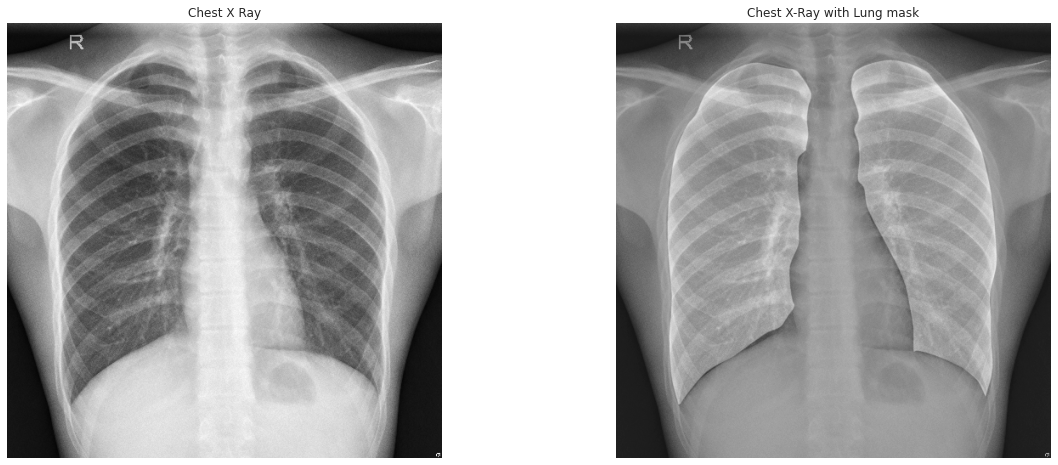

In [7]:
show_chest(fnames[50])

In [8]:
gc.collect()

3835

In [0]:
data = (SegmentationItemList.from_folder(path=path/'train')
        .split_by_rand_pct(0.2)
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), size=128, tfm_y=True)
        .databunch(bs=32)
        .normalize(imagenet_stats))

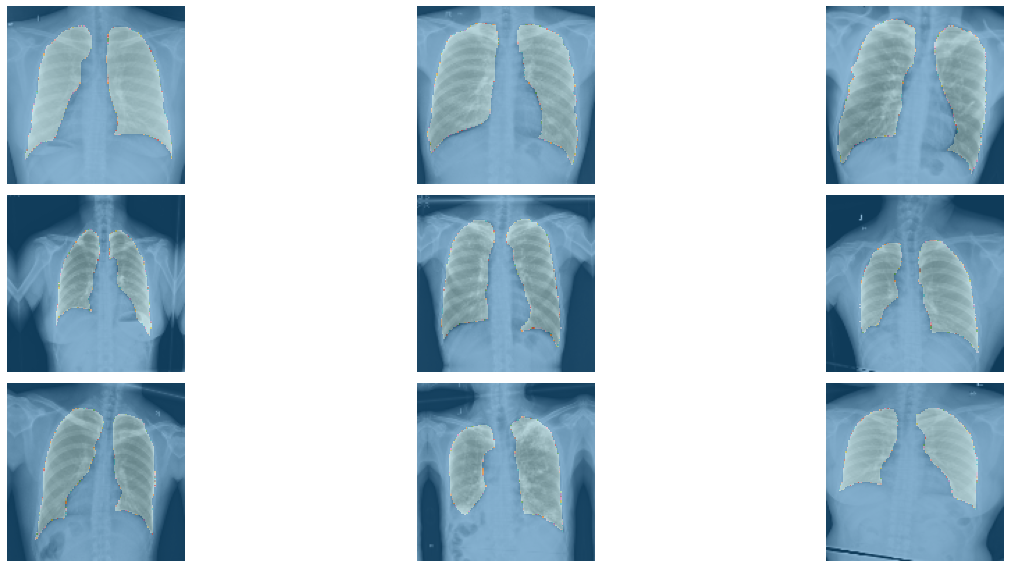

In [55]:
data.show_batch(rows=3,figsize=(20,8));

In [56]:
len(data.train_ds),len(data.valid_ds)

(453, 113)

# Model

* Metrics for lung mask

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = -1

def accuracy_mask(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=accuracy_mask
wd=1e-2    # wd = weight decay

In [0]:
learn = unet_learner(data, models.resnet18, metrics = [accuracy_mask], wd = wd, bottle=True, model_dir = '/content/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


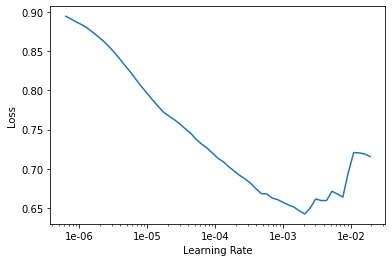

In [11]:
learn.lr_find()
learn.recorder.plot()

In [13]:
gc.collect()

0

In [0]:
lr =1e-3

In [15]:
learn.fit_one_cycle(10, slice(lr) )

epoch,train_loss,valid_loss,accuracy_mask,time
0,0.338625,0.222636,0.741549,00:13
1,0.224597,0.103500,0.729626,00:10
2,0.174275,0.090105,0.730470,00:10
3,0.144722,0.082825,0.734548,00:10
4,0.125493,0.079284,0.735672,00:10
5,0.113133,0.078534,0.735514,00:10
6,0.104667,0.078483,0.734963,00:10
7,0.098882,0.082471,0.738035,00:10
8,0.094381,0.077295,0.734782,00:10
9,0.090417,0.077185,0.735764,00:10


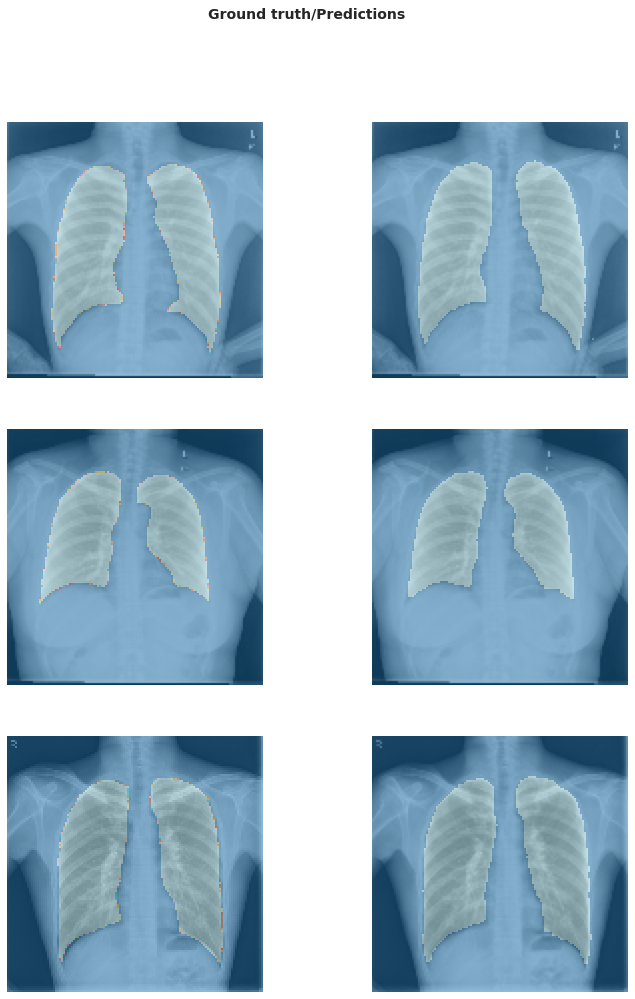

In [16]:
learn.show_results(rows=3, figsize=(12,16))

In [0]:
learn.save('stage-1-big')
learn.load('stage-1-big');
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


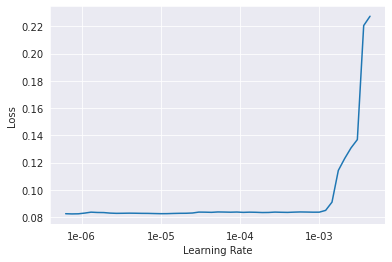

In [274]:
learn.lr_find()
learn.recorder.plot()

In [276]:
gc.collect()

5791

In [0]:
lrs = slice(lr/100,lr)

In [278]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_mask,time
0,0.086361,0.081362,0.735379,00:08
1,0.084348,0.078850,0.741617,00:09
2,0.083935,0.077149,0.739439,00:08
3,0.083861,0.079640,0.736060,00:08
4,0.083253,0.076715,0.739815,00:08
5,0.085824,0.097111,0.743637,00:08
6,0.087258,0.079904,0.736800,00:08
7,0.085702,0.077412,0.736799,00:08
8,0.084879,0.080301,0.742556,00:08
9,0.083844,0.081048,0.740893,00:08


## Export the model

In [0]:
learn.export('/content/chest_mask.pkl')

In [0]:
!cp '/content/chest_mask.pkl' '/content/drive/My Drive/Dataset/'

### Load the model  and predict

In [0]:
model = load_learner('/content/drive/My Drive/Dataset/','chest_mask.pkl')
def chest_predict(f):
  pred=model.predict(open_image(f))[0]
  im = Image.open(f)
  pred.show(figsize=(6,6),alpha=0.9,title='Chest X Ray with predicted mask')
  plt.imshow(np.asarray(im.resize((128, 128))),alpha=0.7)

### Prediction

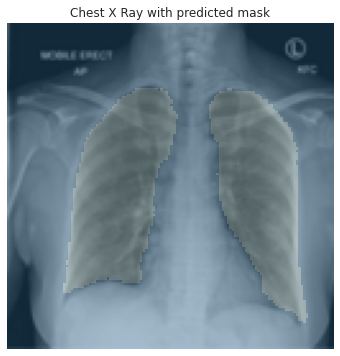

In [28]:
chest_predict('/content/41591_2020_819_Fig1_HTML.webp-day10.png_I.png')

## Model Summary

In [81]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________